In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn import preprocessing

In [2]:
path=r"C:\Users\Shibbs\Desktop\Praxis\CAPP\cwd\datasets\final\df.csv"

In [5]:
df = pd.read_csv(path)

C:\Users\Shibbs\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.columns

Index(['Unnamed: 0', 'event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [7]:
def get_dataset(path):
    
    df = pd.read_csv(path, dtype={ 'event_type':object, 'product_id':int, 'category_id':object,
                                   'category_code':object, 'brand':str, 'price':float, 'user_id':object, 
                                   'user_session':object})
    df = df.groupby(['user_id', 'event_time'], as_index=False).first()
    df = df.drop_duplicates(subset=['user_id', 'event_time'])
    df = df[['user_id','event_type']]
    
    return df

In [8]:
def prepare_dataset(df,seq_length):
    
    for i in df['user_id'].unique():
        seq = []
        for j in range(df[df.user_id == i].shape[0]):
            seq.append(f"{j}")   
        df.loc[df['user_id']==i,'seq_index'] = [k for k in seq]
        
    df.seq_index = df.seq_index.astype(int)  
    df = df[df['seq_index']<seq_length].reset_index()
    
    df2 = pd.pivot_table(data=df,index='user_id',columns=['seq_index'],values=['event_type'],aggfunc='sum')
    df2 = df2.fillna(0)
    df2 = df2.replace(['view'],1)
    df2 = df2.replace(['cart'],2)
    df2 = df2.replace(['purchase'],3)
    df2 = df2[df2['event_type',  1 ]!= 0]
    
    df3 = pd.pivot_table(data=df,index='user_id',columns=['seq_index'],values=['product_id'],aggfunc='sum')
    df3 = df3.fillna(0)
    df3 = df3[df3['product_id',  1 ]!= 0]
    
    event_type_list = []
    for i in range(len(df2.index)):
        event_type = df2.iloc[i].tolist()
        event_type.sort(reverse = True,key=lambda x: x==0)
        event_type_list.append(event_type)
        
    product_id_list = []
    for i in range(len(df2.index)):
        product_id = df2.iloc[i].tolist()
        product_id.sort(reverse = True,key=lambda x: x==0)
        product_id_list.append(product_id)
    
        
    return event_type_list, product_id_list
    

In [9]:
def train(arr, epochs, batch_size):
    train_size = 10000
    train = arr[:train_size, :]
    test = arr[train_size:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print('train_X: {} train_y: {} test_X: {} test_y: {}'.format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.7))
    model.add(BatchNormalization())
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),dropout=0.7))
    model.add(BatchNormalization())
    model.add(Dense(64,activation='relu'))
    model.add(Dense(53452 + 4,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
    # fit network
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=True)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    return model

In [10]:
def make_pred(model, data):
    user_array = np.array(data)
    user_array = user_array.reshape((user_array.shape[0], 1, user_array.shape[1]))
#     pred = np.argmax(model.predict(user_array))
    pred = model.predict(user_array)
    scaled_pred = np.argmax(pred[0][1]*(1/(data == 1).sum()),pred[0][2]*(1/(data == 2).sum()),pred[0][3]*(1/(data == 3).sum()))
    return scaled_pred
    

In [11]:
df = get_dataset(path)

In [8]:
data = prepare_dataset(df,150)

train_X: (10000, 1, 149) train_y: (10000,) test_X: (879, 1, 149) test_y: (879,)
Epoch 1/10
313/313 - 4s - loss: 0.4566 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.5139 - val_sparse_categorical_accuracy: 0.8851 - 4s/epoch - 13ms/step
Epoch 2/10
313/313 - 1s - loss: 0.3823 - sparse_categorical_accuracy: 0.9102 - val_loss: 0.4413 - val_sparse_categorical_accuracy: 0.8851 - 773ms/epoch - 2ms/step
Epoch 3/10
313/313 - 1s - loss: 0.3753 - sparse_categorical_accuracy: 0.9102 - val_loss: 0.4416 - val_sparse_categorical_accuracy: 0.8851 - 750ms/epoch - 2ms/step
Epoch 4/10
313/313 - 1s - loss: 0.3755 - sparse_categorical_accuracy: 0.9102 - val_loss: 0.4522 - val_sparse_categorical_accuracy: 0.8851 - 765ms/epoch - 2ms/step
Epoch 5/10
313/313 - 1s - loss: 0.3724 - sparse_categorical_accuracy: 0.9102 - val_loss: 0.4390 - val_sparse_categorical_accuracy: 0.8851 - 750ms/epoch - 2ms/step
Epoch 6/10
313/313 - 1s - loss: 0.3680 - sparse_categorical_accuracy: 0.9102 - val_loss: 0.4347 - val_spars

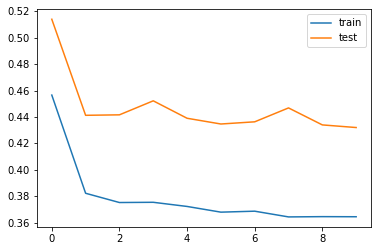

In [48]:
model = train(data, 10, 32)